# U.S. Medical Insurance Costs

### Matteo Caponi- Project 2 

### The scope of this project is to create a regression model in order to predict insurance cost based on the variables given: age, sex, bmi, number of children, smoker status, region. 

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [138]:
insurance_file=pd.read_csv('insurance.csv')
insurance_file.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [139]:
print(insurance_file.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


In [140]:
insurance_file.describe()

age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

In [141]:
sns.pairplot(insurance_file)

### Project Goal--Determine the function used to calculate cost with the variables given

In [142]:
# converting sex and smoker in bool 
sex={'male':0, 'female':1}
smoker={'yes':0, 'no':1}
insurance_file['sex']=insurance_file['sex'].map(sex)
insurance_file['smoker']=insurance_file['smoker'].map(smoker)

In [143]:
# replacing ragion strings with int
insurance_file['region'].unique()
region={'southwest':1,'southeast':2,'northwest':3,'northeast':4}
insurance_file['region']=insurance_file['region'].map(region)

In [144]:
## split variables and target, cost=target, variables= everything else
target=insurance_file.iloc[:,-1:]
variables=insurance_file.iloc[:,:-1]

In [145]:
## checking for missing values 
target.replace([np.inf, -np.inf, -999, '', 'inf', 'NaN', None,'   ', 'XXX'], np.nan, inplace= True) 
variables.replace([np.inf, -np.inf, -999, '', 'inf', 'NaN', None,'   ', 'XXX'], np.nan, inplace= True) 
print(target.isna().any())
print(variables.isna().any())

charges    False
dtype: bool
age         False
sex         False
bmi         False
children    False
smoker      False
region      False
dtype: bool


In [146]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(variables, target, test_size=0.25, random_state=42)

In [147]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [148]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=3, shuffle = True, random_state=125)

### Linear Regression 

In [149]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()

X_train_s = scl.fit_transform(X_train)
X_test_s = scl.transform(X_test)

X_trains = pd.DataFrame(X_train_s, columns=X_train.columns, index=X_train.index)
X_tests=pd.DataFrame(X_test_s, columns=X_test.columns, index=X_test.index)

In [150]:
rd = Ridge(alpha=1)
rd1=rd.fit(X_trains, y_train) 

In [151]:
alpha = [0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
param_grid = dict(alpha=alpha)

grid = RandomizedSearchCV(rd1, param_grid, cv = cv, scoring = 'neg_mean_absolute_error',n_iter=5,n_jobs=50)
grid.fit(X_trains, y_train.values.ravel())
y_pred = grid.predict(X_tests)
print(grid.best_params_)
print('MAE score for this prediction is {}'.format(grid.best_score_))

{'alpha': 1e-05}
MAE score for this prediction is -4217.818514553749


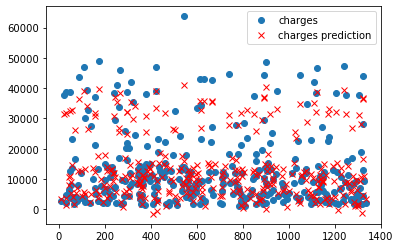

In [152]:
y_pred_df = pd.DataFrame(y_pred, columns=['charges prediction'], index=y_test.index)
comparison=pd.concat([y_test, y_pred_df], axis=1)
comparison.plot(style=['o','rx'])

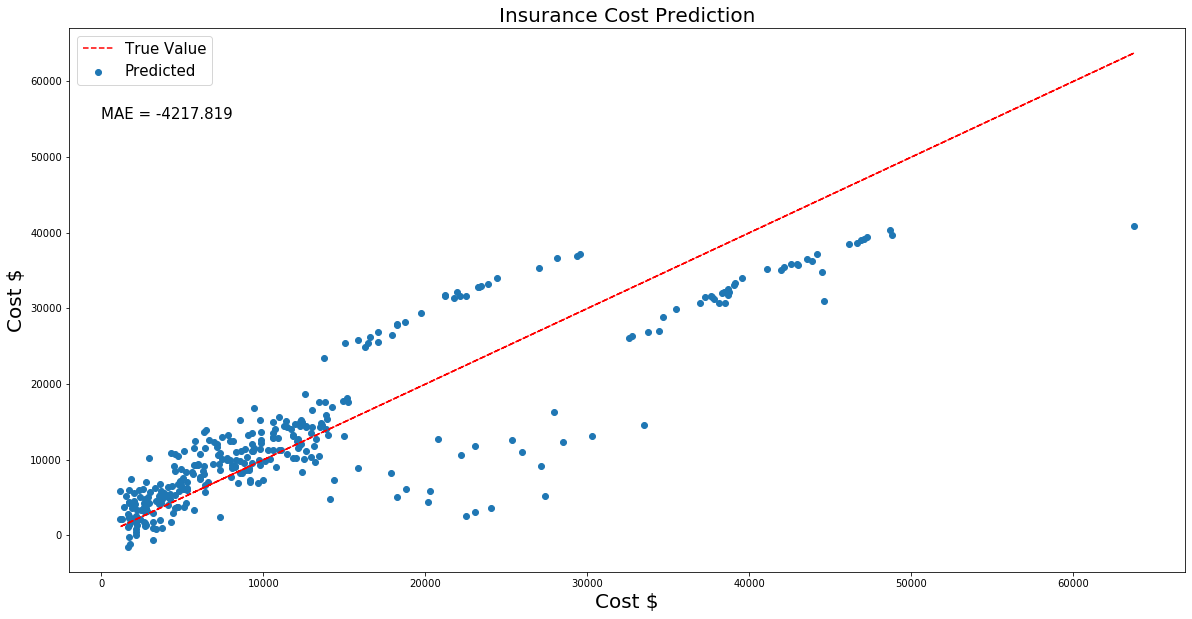

In [153]:
fig=plt.figure()
ax = fig.add_subplot(111,title='Insurance Cost Prediction')
ax.set_ylabel('Cost $', fontsize = 20.0) 
ax.set_xlabel('Cost $', fontsize = 20)
ax.set_title('Insurance Cost Prediction', fontsize= 20)
ax.scatter(np.array(y_test),np.array(y_pred_df),label='Predicted')
ax.plot(np.array(y_test),np.array(y_test),'--r',label='True Value')
ax.legend(loc='upper left', prop={'size': 15})
ax.annotate("MAE = {:.3f}".format(grid.best_score_), (0, 55000),fontsize=15)
fig.set_figheight(10)
fig.set_figwidth(20)

### Non-linear Regression

In [154]:
rfr =  RandomForestRegressor(n_estimators=200,min_samples_leaf=1)

rfr1=rfr.fit(X_train, y_train.values.ravel())

In [155]:
max_features = [1,2,3,4, 'auto']
max_depth = [4,8,15,30,None]
min_samples_leaf=[0,1,2,3,5]
n_estimators=[50,100,200,300,400]
param_grid = dict( max_features = max_features, max_depth = max_depth, min_samples_leaf=min_samples_leaf)

grid = RandomizedSearchCV(rfr1, param_grid, cv = cv, scoring = 'neg_mean_absolute_error',n_iter=50,n_jobs=50)
grid.fit(X_train, y_train.values.ravel())
y_pred = grid.predict(X_test)
print(grid.best_params_)
print('MAE score for this prediction is {}'.format(grid.best_score_))

{'min_samples_leaf': 3, 'max_features': 4, 'max_depth': 8}
MAE score for this prediction is -2541.1091698670725


In [156]:
y_pred_df = pd.DataFrame(y_pred, columns=['charges prediction'], index=y_test.index)
comparison=pd.concat([y_test, y_pred_df], axis=1)

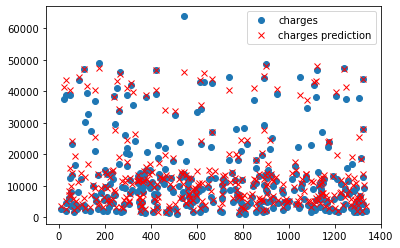

In [157]:
comparison.plot(style=['o','rx'])

In [158]:
fig=plt.figure()
ax = fig.add_subplot(111,title='Insurance Cost Prediction')
ax.set_ylabel('Cost $', fontsize = 20.0) 
ax.set_xlabel('Cost $', fontsize = 20)
ax.set_title('Insurance Cost Prediction', fontsize= 20)
ax.scatter(np.array(y_test),np.array(y_pred_df),label='Predicted')
ax.plot(np.array(y_test),np.array(y_test),'--r',label='True Value')
ax.legend(loc='upper left', prop={'size': 15})
ax.annotate("MAE = {:.3f}".format(grid.best_score_), (0, 55000),fontsize=15)
fig.set_figheight(10)
fig.set_figwidth(20)

### Non linear regression provides a more accurate model

In [159]:
from sklearn.inspection import permutation_importance
feature_importance = rfr1.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance Insurance Cost')

result = permutation_importance(rfr1, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_test.columns)[sorted_idx])
plt.title("Permutation Importance Insurance Cost")
fig.tight_layout()
plt.show()

### Smoker status has the greatest importance, while sex has the least. 

In [160]:
import pickle
insurance_cost = 'insurance_cost_model.sav'
pickle.dump(grid, open(insurance_cost, 'wb'))

#### Taking into account only age between 20 and 30 years to see if sex has higher importance in regression 

In [164]:
insurance_file1=insurance_file[(insurance_file.age>=20) & (insurance_file.age<=30)]
insurance_file1

age  sex     bmi  children  smoker  region      charges
2      28    0  33.000         3       1       2   4449.46200
10     25    0  26.220         0       1       4   2721.32080
12     23    0  34.400         0       1       1   1826.84300
14     27    0  42.130         0       0       2  39611.75770
17     23    0  23.845         0       1       4   2395.17155
...   ...  ...     ...       ...     ...     ...          ...
1308   25    1  30.200         0       0       1  33900.65300
1314   30    1  23.655         3       0       3  18765.87545
1328   23    1  24.225         2       1       4  22395.74424
1331   23    1  33.400         0       1       1  10795.93733
1336   21    1  25.800         0       1       1   2007.94500

[307 rows x 7 columns]

In [166]:
target1=insurance_file1.iloc[:,-1:]
variables1=insurance_file1.iloc[:,:-1]

In [167]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(variables1, target1, test_size=0.25, random_state=42)

In [168]:
rfr2=rfr.fit(X_train1, y_train1.values.ravel())
grid1 = RandomizedSearchCV(rfr2, param_grid, cv = cv, scoring = 'neg_mean_absolute_error',n_iter=50,n_jobs=50)
grid1.fit(X_train1, y_train1.values.ravel())
y_pred1 = grid1.predict(X_test1)
print(grid1.best_params_)
print('MAE score for this prediction is {}'.format(grid1.best_score_))

{'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 30}
MAE score for this prediction is -2672.713934070974


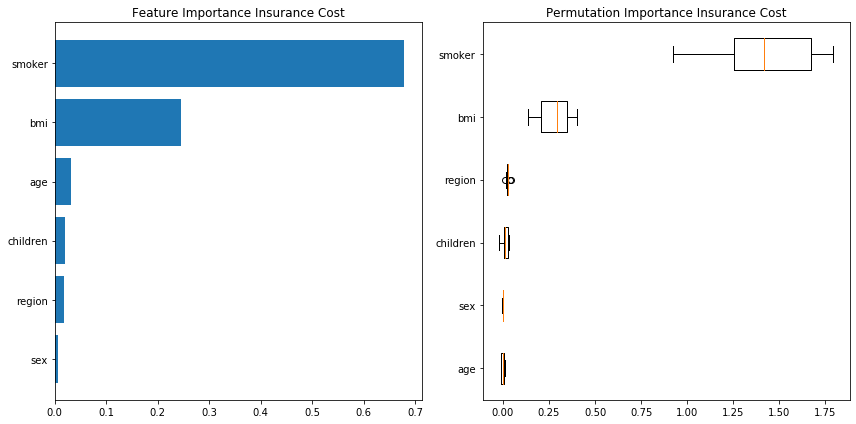

In [169]:
from sklearn.inspection import permutation_importance
feature_importance = rfr2.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_test1.columns)[sorted_idx])
plt.title('Feature Importance Insurance Cost')

result = permutation_importance(rfr2, X_test1, y_test1, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_test1.columns)[sorted_idx])
plt.title("Permutation Importance Insurance Cost")
fig.tight_layout()
plt.show()

### In the age group (20-30) sex is still the least important feature. Chances of pregnacy for the female patients 
### do not increase the cost compared to males of the same age group. 